In [1]:
import re
import os
from collections import Counter

import numpy as np

import matplotlib.pyplot as plt

import nltk

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

## Data preparation

Some files are in latin-1 encoding so we are converting them to utf-8

In [2]:
for filename in os.listdir(os.path.abspath("data/spam")):
    try:
        with open(os.path.join("data/spam", filename), "r", encoding="utf-8") as file:
            content = file.read()
    except UnicodeDecodeError:
        with open(os.path.join("data/spam", filename), "r", encoding="latin-1") as file:
            content = file.read()
        with open(os.path.join("data/spam", filename), "w", encoding="utf-8") as file:
            file.write(content)
for filename in os.listdir(os.path.abspath("data/ham")):
    try:
        with open(os.path.join("data/ham", filename), "r", encoding="utf-8") as file:
            content = file.read()
    except UnicodeDecodeError:
        with open(os.path.join("data/ham", filename), "r", encoding="latin-1") as file:
            content = file.read()
        with open(os.path.join("data/ham", filename), "w", encoding="utf-8") as file:
            file.write(content)

The preprocessing function that handles tokenization and stemming

In [3]:
def preprocessing(file):
    file.seek(0)
    
    # strip metadata
    while file.readline() != '\n':
        pass
    
    # lower case
    mail = file.read().lower()
    
    # html
    mail = re.sub('<[^<>]+>', ' ', mail)
    
    # dollars
    mail = mail.replace('$', "dollar")
    
    # urls
    mail = re.sub(r'(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', 
                  "httpaddr",
                  mail)
    
    # emails
    mail = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', "emailaddr", mail)
    
    # numbers
    mail = re.sub(r'\d+', "number", mail)
    
    # tokenize
    tokenizer = nltk.tokenize.TreebankWordTokenizer()
    tokens = tokenizer.tokenize(mail)
    
    # stemming
    stemmer = nltk.stem.snowball.SnowballStemmer("english")
    tokens = [stemmer.stem(token) for token in tokens if token.isalpha()]
    
    return tokens

The creation of a vocabulary

In [4]:
raw_vocab = []
for filename in os.listdir(os.path.abspath("data/spam")):
    with open(os.path.join("data/spam", filename), "r", encoding="utf-8") as file_content:
        tokens = preprocessing(file_content)
        raw_vocab += tokens
for filename in os.listdir(os.path.abspath("data/ham")):
    with open(os.path.join("data/ham", filename), "r", encoding="utf-8") as file_content:
        tokens = preprocessing(file_content)
        raw_vocab += tokens

nltk.download('stopwords', quiet=True)
stopwords = nltk.corpus.stopwords.words('english')
raw_vocab = [x for x in raw_vocab if x not in stopwords]
print("There are", len(raw_vocab), "different tokens")

There are 586079 different tokens


Removing the less frequent words, and keeping only the 10 000 most frequent words

In [5]:
vocabulary_size = 5000
bag_of_words = Counter(raw_vocab)
vocab = [x[0] for x in bag_of_words.most_common(vocabulary_size)]
print("There are", len(vocab), "different tokens after cleaning")

There are 5000 different tokens after cleaning


In [6]:
word_to_index = {}
index_to_word = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index + 1
    index_to_word[index + 1] = word

In [7]:
def encoding_tokens(tokens):
    return [word_to_index.get(word, 0) for word in tokens if word in word_to_index]

In [8]:
def transform(file):
    tokens = preprocessing(file)
    encoded_tokens = encoding_tokens(tokens)
    return encoded_tokens

In [9]:
class MailDataset(Dataset):
    def __init__(self, 
            pos_files,
            neg_files,
            transform=transform,
            positive_class_dir="data/spam",
            negative_class_dir="data/ham"):
        
        self.positive_class_dir = positive_class_dir
        self.negative_class_dir = negative_class_dir
        
        self.pos_files = pos_files
        self.neg_files = neg_files
        
        self.transform = transform
        
        self.mails = []
        for file in self.pos_files:
            mail_path = os.path.join(self.positive_class_dir, file)
            label = 1
            with open(mail_path, "r", encoding="utf-8") as file:
                mail = [0] + transform(file)
            self.mails.append((mail, label))
        for file in self.neg_files:
            mail_path = os.path.join(self.negative_class_dir, file)
            label = 0
            with open(mail_path, "r", encoding="utf-8") as file:
                mail = [0] + transform(file)
            self.mails.append((mail, label))
        
    def __len__(self):
        return len(self.mails)
    
    def __getitem__(self, idx):
        mail, label = self.mails[idx]
        return torch.unsqueeze(torch.as_tensor(mail), dim=-1).float(), torch.as_tensor(label).float()

Creating test and train sets

In [10]:
def create_train_test_dataset(
        test_ratio=0.3,
        positive_class_dir="data/spam",
        negative_class_dir="data/ham"):
    
    pos_files = os.listdir(os.path.abspath(positive_class_dir))
    neg_files = os.listdir(os.path.abspath(negative_class_dir))
    
    shuffled_pos_indices = np.random.permutation(len(pos_files))
    shuffled_neg_indices = np.random.permutation(len(neg_files))

    pos_test_set_size = int(len(pos_files) * test_ratio)
    neg_test_set_size = int(len(neg_files) * test_ratio)
    
    pos_train_indices = shuffled_pos_indices[pos_test_set_size:]
    pos_test_indices = shuffled_pos_indices[:pos_test_set_size]
    
    neg_train_indices = shuffled_neg_indices[neg_test_set_size:]
    neg_test_indices = shuffled_neg_indices[:neg_test_set_size]
    
    pos_train_files = [pos_files[i] for i in pos_train_indices]
    neg_train_files = [neg_files[i] for i in neg_train_indices]
    
    pos_test_files = [pos_files[i] for i in pos_test_indices]
    neg_test_files = [neg_files[i] for i in neg_test_indices]
    
    train_dataset = MailDataset(pos_train_files, neg_train_files)
    test_dataset = MailDataset(pos_test_files, neg_test_files)
    
    return train_dataset, test_dataset

In [11]:
def pad_collate(batch):
    X = [item[0] for item in batch]
    y = [item[1] for item in batch]
    X_pad = pad_sequence(X, batch_first=True)
    return X_pad, torch.as_tensor(y).view(-1, 1)

Creating data loaders for train and test sets

In [12]:
train_dataset, test_dataset = create_train_test_dataset()
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=pad_collate)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=pad_collate)

## Model selection

### Deep model

#### LSTM

In [13]:
class Wrapper:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.model.to(self.device)
        
        self.train_loader = None
        self.val_loader = None
        
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

    def set_loaders(self, train_loader, val_loader=None):
        self.train_loader = train_loader
        self.val_loader = val_loader
        
    def train_step(self, X, y):
        self.model.train()
        
        yhat = self.model(X)
        
        loss = self.loss_fn(yhat, y)
        loss.backward()
        
        self.optimizer.step()
        self.optimizer.zero_grad()
        
        return loss.item()
    
    def val_step(self, X, y):
        self.model.eval()
        
        yhat = self.model(X)
        
        loss = self.loss_fn(yhat, y)
        
        return loss.item()
    
    def _mini_batch(self, validation=False):
        if validation:
            data_loader = self.val_loader
            step = self.val_step
        else:
            data_loader = self.train_loader
            step = self.train_step
            
        if data_loader is None:
            return None
        
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
 
            mini_batch_loss = step(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)
 
        loss = np.mean(mini_batch_losses)
    
        return loss
    
    def train(self, n_epochs):
        for epoch in range(n_epochs):
    
            self.total_epochs += 1

            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            with torch.no_grad():

                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)
    
            scalars = {'training': loss}
            if val_loss is not None:
                scalars.update({'validation': val_loss})
            
            print("epoch: {0} | training loss: {1:.2f} | validation loss: {2:.2f}"
                  .format(epoch, scalars["training"], scalars["validation"]))
                
    def predict(self, x):
        self.model.eval()
        with torch.no_grad():
            y_hat_tensor = torch.sigmoid(self.model(x.to(self.device)))
        self.model.train()
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        if self.val_loader:
            plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None
        self.cell = None
        self.rnn = nn.LSTM(self.n_features,
                                 self.hidden_dim,
                                 batch_first=True)
        self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)

    def forward(self, X):
        batch_first_output, (self.hidden, self.cell) = \
                                            self.rnn(X)
        last_output = batch_first_output[:, -1]
        out = self.classifier(last_output)
        return out.view(-1, self.n_outputs)

In [15]:
lstm_model = LSTMModel(n_features=1, hidden_dim=128, n_outputs=1)
optimizer = Adam(lstm_model.parameters())
loss_fn = nn.BCEWithLogitsLoss(reduction='mean')

lstm_wrapper = Wrapper(lstm_model, loss_fn, optimizer)

epoch: 0 | training loss: 0.69 | validation loss: 0.69
epoch: 1 | training loss: 0.69 | validation loss: 0.68
epoch: 2 | training loss: 0.69 | validation loss: 0.69
epoch: 3 | training loss: 0.69 | validation loss: 0.69
epoch: 4 | training loss: 0.69 | validation loss: 0.69
epoch: 5 | training loss: 0.69 | validation loss: 0.69
epoch: 6 | training loss: 0.69 | validation loss: 0.69
epoch: 7 | training loss: 0.69 | validation loss: 0.68
epoch: 8 | training loss: 0.68 | validation loss: 0.69
epoch: 9 | training loss: 0.68 | validation loss: 0.68
epoch: 10 | training loss: 0.68 | validation loss: 0.68
epoch: 11 | training loss: 0.68 | validation loss: 0.68
epoch: 12 | training loss: 0.68 | validation loss: 0.69
epoch: 13 | training loss: 0.68 | validation loss: 0.68
epoch: 14 | training loss: 0.68 | validation loss: 0.67
epoch: 15 | training loss: 0.68 | validation loss: 0.68
epoch: 16 | training loss: 0.68 | validation loss: 0.69
epoch: 17 | training loss: 0.67 | validation loss: 0.68
ep

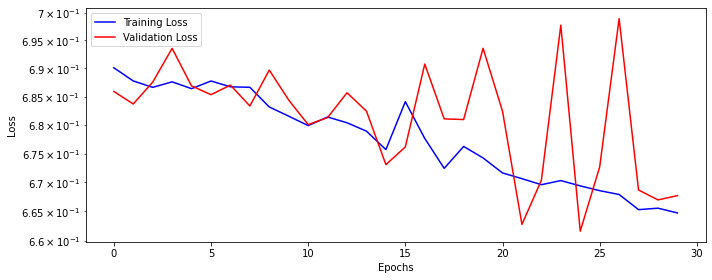

In [16]:
lstm_wrapper.set_loaders(train_dataloader, test_dataloader)
lstm_wrapper.train(n_epochs=30)
lstm_wrapper.plot_losses()

threshold is 0.6129136085510254 | accuracy is 76.34%


Text(0.5, 0, 'False positive rate')

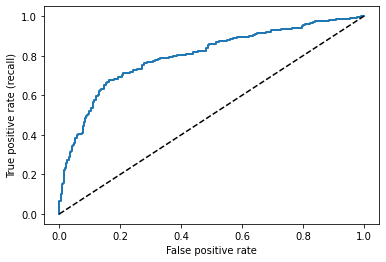

In [17]:
test_full = [(x[0], x[1].item()) for x in test_dataset]

test_prediction_scores, test_y = zip(*[(lstm_wrapper.predict(torch.unsqueeze(x, dim=0)).item(), y) \
                                       for x, y in list(test_full) if x.shape[0] > 0])


fpr, tpr, thresholds = roc_curve(test_y, test_prediction_scores)

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = thresholds[ix]
test_prediction = np.asarray([ 1 if x > threshold else 0 for x in test_prediction_scores])
print("threshold is {0} | accuracy is {1:.2f}%"
      .format(threshold, (test_prediction==np.asarray(test_y)).mean() * 100))

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")

#### Linear

In [18]:
def ann_email_embedding(batch):
    X = [item[0] for item in batch]
    y = [item[1] for item in batch]
    
    bow = torch.zeros((len(X), vocabulary_size))
    
    for i, email in enumerate(X):
        for word_index in email:
            if (word_index.int().item() > 0):
                bow[i, word_index.int().item() - 1] = 1
    return bow, torch.as_tensor(y).view(-1, 1)

In [19]:
bow_train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=ann_email_embedding)
bow_test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=ann_email_embedding)

In [20]:
class LinearModel(nn.Module):
    def __init__(self, n_features, n_outputs):
        super(LinearModel, self).__init__()
        self.n_features = n_features
        self.n_outputs = n_outputs
        
        self.linear1 = nn.Linear(self.n_features, 256, bias=False)
        self.batchnorm1 = nn.BatchNorm1d(256)
        
        self.linear2 = nn.Linear(256, 128, bias=False)
        self.batchnorm2 = nn.BatchNorm1d(128)
        
        self.linear3 = nn.Linear(128, self.n_outputs)
        
    def forward(self, X):
        out = self.linear1(X)
        out = self.batchnorm1(out)
        out = nn.functional.relu(out)
        
        out = self.linear2(out)
        out = self.batchnorm2(out)
        out = nn.functional.relu(out)
        
        out = self.linear3(out)
        
        return out.view(-1, self.n_outputs)

In [21]:
linear_model = LinearModel(n_features=vocabulary_size, n_outputs=1)
optimizer = Adam(linear_model.parameters())
loss_fn = nn.BCEWithLogitsLoss(reduction='mean')

linear_wrapper = Wrapper(linear_model, loss_fn, optimizer)

epoch: 0 | training loss: 0.18 | validation loss: 0.09
epoch: 1 | training loss: 0.09 | validation loss: 0.11
epoch: 2 | training loss: 0.07 | validation loss: 0.12
epoch: 3 | training loss: 0.06 | validation loss: 0.09
epoch: 4 | training loss: 0.04 | validation loss: 0.09
epoch: 5 | training loss: 0.03 | validation loss: 0.11
epoch: 6 | training loss: 0.06 | validation loss: 0.11
epoch: 7 | training loss: 0.04 | validation loss: 0.12
epoch: 8 | training loss: 0.04 | validation loss: 0.11
epoch: 9 | training loss: 0.02 | validation loss: 0.11
epoch: 10 | training loss: 0.02 | validation loss: 0.12
epoch: 11 | training loss: 0.02 | validation loss: 0.12
epoch: 12 | training loss: 0.01 | validation loss: 0.13
epoch: 13 | training loss: 0.01 | validation loss: 0.13
epoch: 14 | training loss: 0.01 | validation loss: 0.12
epoch: 15 | training loss: 0.02 | validation loss: 0.13
epoch: 16 | training loss: 0.02 | validation loss: 0.16
epoch: 17 | training loss: 0.04 | validation loss: 0.12
ep

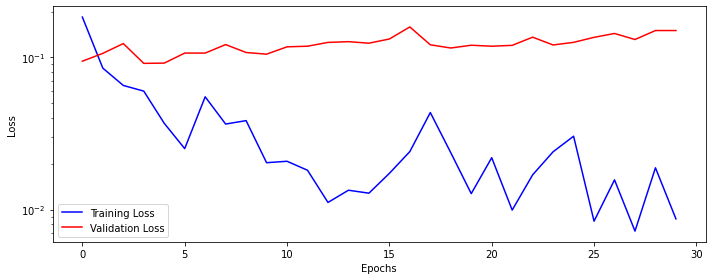

In [22]:
linear_wrapper.set_loaders(bow_train_dataloader, bow_test_dataloader)
linear_wrapper.train(n_epochs=30)
linear_wrapper.plot_losses()

threshold is 0.6552371978759766 | accuracy is 96.50%


Text(0.5, 0, 'False positive rate')

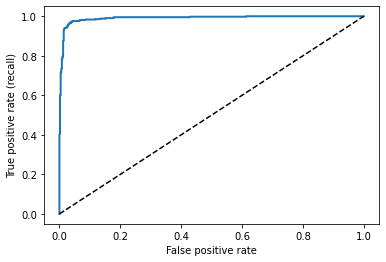

In [23]:
test_full = [ann_email_embedding([(x[0], x[1])]) for x in test_dataset]

test_prediction_scores, test_y = zip(*[(linear_wrapper.predict(x).item(), y.item()) \
                                       for x, y in list(test_full) if x.shape[0] > 0])

fpr, tpr, thresholds = roc_curve(test_y, test_prediction_scores)

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = thresholds[ix]
test_prediction = np.asarray([ 1 if x > threshold else 0 for x in test_prediction_scores])
print("threshold is {0} | accuracy is {1:.2f}%"
      .format(threshold, (test_prediction==np.asarray(test_y)).mean() * 100))

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")

### SVM model

In [24]:
def email_embedding(email):
    embedding = np.zeros((1, vocabulary_size))
    for word_index in email:
        if (word_index.int().item() > 0):
            embedding[0, word_index.int().item() - 1] = 1
    return embedding

In [25]:
train_full = np.asarray([np.append(email_embedding(x[0]), x[1].item()) for x in train_dataset])
train_X, train_y = train_full[:, :-1], train_full[:, -1]

test_full = np.asarray([np.append(email_embedding(x[0]), x[1].item()) for x in test_dataset])
test_X, test_y = test_full[:, :-1], test_full[:, -1]

print("train set: x {}, y {}\ntest set: x {}, y {}".format(train_X.shape, train_y.shape, test_X.shape, test_y.shape))

train set: x (2133, 5000), y (2133,)
test set: x (913, 5000), y (913,)


In [26]:
svm_model = SVC(C=0.1, kernel="linear")
svm_model.fit(train_X, train_y)

SVC(C=0.1, kernel='linear')

In [27]:
train_prediction = svm_model.predict(train_X)
test_prediction = svm_model.predict(test_X)

train_accuracy = (train_prediction == train_y).mean() * 100
test_accuracy = (test_prediction == test_y).mean() * 100

print("train accuracy: {0:.10f}%".format(train_accuracy))
print("test accuracy: {0:.10f}%".format(test_accuracy))

train accuracy: 99.7655883732%
test accuracy: 96.3855421687%


with threshold = -0.16575786661088332 | test accuracy is 96.82%


Text(0.5, 0, 'False positive rate')

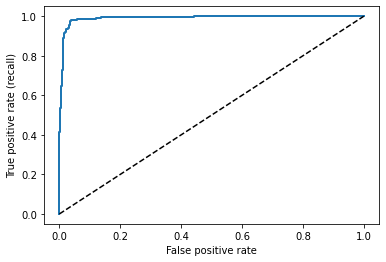

In [28]:
train_prediction_scores = svm_model.decision_function(train_X)
test_prediction_scores = svm_model.decision_function(test_X)

fpr, tpr, thresholds = roc_curve(test_y, test_prediction_scores)

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = thresholds[ix]
test_prediction = np.asarray([ 1 if x > threshold else 0 for x in test_prediction_scores])
print("with threshold = {0} | test accuracy is {1:.2f}%"
      .format(threshold, (test_prediction==np.asarray(test_y)).mean() * 100))

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")